In [43]:
# Importación de las librerías necesarias
# Se importan las librerías esenciales para el manejo de arrays, imágenes, la construcción del modelo y la evaluación del desempeño.
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score

In [44]:
# Definimos el tamaño de las imágenes (32x32 píxeles)
# Este tamaño lo elegí para mantener la simplicidad del modelo y acelerar el tiempo de entrenamiento. 
IMG_SIZE = 32

# Función para cargar el dataset UTKFace
# La función 'load_utkface_data' carga las imágenes desde un directorio y extrae la edad del nombre del archivo.
# Se realizarón los pasos de validación para asegurarse de que las imágenes y sus etiquetas sean correctas y estén en el formato esperado.
def load_utkface_data(dataset_path):
    images = []  # Lista para almacenar las imágenes cargadas
    labels = []  # Lista para almacenar las etiquetas (edades)

    # Iteramos sobre los archivos en el directorio
    for filename in os.listdir(dataset_path):
        if filename.endswith(".jpg"):  # Filtramos solo archivos de imagen
            parts = filename.split('_')
            
            # Validar formato del nombre del archivo (debe tener 4 partes separadas por guiones bajos)
            if len(parts) != 4:
                print(f"Archivo con formato no válido ignorado: {filename}")
                continue
            
            label = int(parts[0])  # Extraer la edad del nombre del archivo
            
            # Cargar la imagen usando OpenCV
            img = cv2.imread(os.path.join(dataset_path, filename))
            
            # Si la imagen no se carga correctamente, la ignoramos
            if img is None:
                print(f"Error al cargar la imagen: {filename}")
                continue
            
            # Redimensionamos la imagen al tamaño definido (32x32)
            # Esto permite que todas las imágenes tengan las mismas dimensiones, lo que es necesario para entrenar el modelo.
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            images.append(img)
            labels.append(label)

    # Convertimos las listas a arrays de NumPy, que son estructuras más eficientes para el manejo de grandes cantidades de datos en el entrenamiento
    return np.array(images), np.array(labels)

# Ruta donde se encuentra el dataset
dataset_path = "./UTKFace"

# Carga de los datos
# Llamamos a la función que carga el dataset, retornando las imágenes y las etiquetas correspondientes.
images, labels = load_utkface_data(dataset_path)

Archivo con formato no válido ignorado: 61_1_20170109142408075.jpg.chip.jpg
Archivo con formato no válido ignorado: 61_3_20170109150557335.jpg.chip.jpg


In [45]:
# Esto es un paso crucial para asegurar que los valores de los píxeles estén en un rango más manejable para el modelo (entre 0 y 1 en lugar de 0 a 255),
# lo que facilita el aprendizaje y mejora la estabilidad del entrenamiento, reduciendo el riesgo de que gradientes exploten o se desvanezcan.
images = images.astype('float32') / 255.0

# Dividimos los datos en entrenamiento (80%) y prueba (20%)
# El uso de 'train_test_split' permite dividir los datos de manera aleatoria. 
# La división de 80-20 es una práctica común para asegurar que el modelo tenga suficientes datos para entrenar y evaluar su desempeño de manera efectiva
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalizamos las etiquetas (las edades) entre 0 y 1 usando MinMaxScaler
# En este caso, las edades (etiquetas) también se escalan entre 0 y 1 usando 'MinMaxScaler', lo cual es importante porque los modelos de aprendizaje automático 
# generalmente se desempeñan mejor cuando los valores de entrada y salida están en un rango similar. 
# Además, facilita el uso de funciones de activación como 'sigmoid' o 'tanh', que esperan entradas en rangos normalizados.
scaler = MinMaxScaler()
y_train = scaler.fit_transform(y_train.reshape(-1, 1))
y_test = scaler.transform(y_test.reshape(-1, 1))

# Se imprime el tamaño de los conjuntos de entrenamiento y prueba para asegurarse de que la división se haya realizado correctamente.
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")


Tamaño del conjunto de entrenamiento: (7822, 32, 32, 3)
Tamaño del conjunto de prueba: (1956, 32, 32, 3)


In [46]:
# Definimos la arquitectura del modelo CNN
model = Sequential()

# Primera capa convolucional con más filtros
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda capa convolucional con más filtros
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Tercera capa convolucional
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Aplanamos y agregamos capas densas adicionales
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Capa de salida con 1 neurona (predicción de la edad)
model.add(Dense(1, activation='linear'))

# Compilamos el modelo usando el optimizador Adam y la función de pérdida MSE (error cuadrático medio)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])

# Mostramos un resumen del modelo
model.summary()

c:\Users\jcrod\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 30, 30, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 666,241 (2.54 MB)

 Trainable params: 666,241 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 0.0613 - mae: 0.1997 - val_loss: 0.0404 - val_mae: 0.1654
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0425 - mae: 0.1636 - val_loss: 0.0267 - val_mae: 0.1259
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0297 - mae: 0.1309 - val_loss: 0.0237 - val_mae: 0.1075
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0251 - mae: 0.1171 - val_loss: 0.0191 - val_mae: 0.1007
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0226 - mae: 0.1099 - val_loss: 0.0210 - val_mae: 0.1110
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0197 - mae: 0.1022 - val_loss: 0.0160 - val_mae: 0.0912
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0177 - mae: 0.0968 - val_loss: 0.0156 - val_mae: 0.0913
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0162 - mae: 0.0920 - val_loss: 0.0133 - val_mae: 0.0813
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms

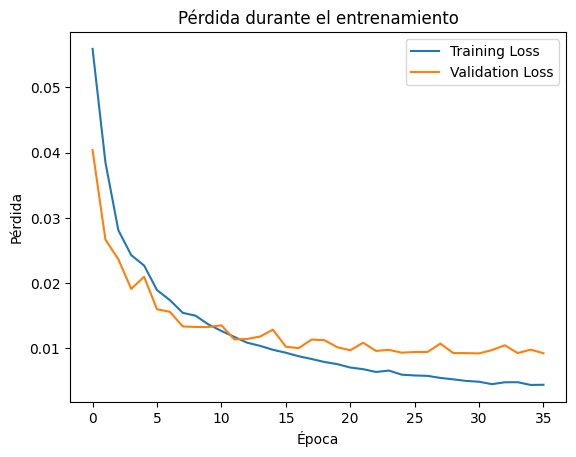

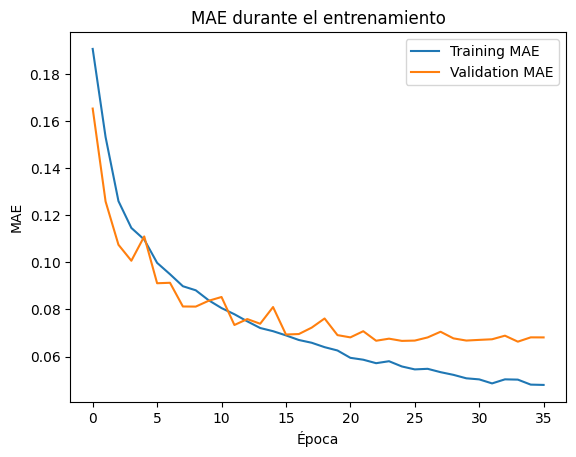

In [47]:
# Definimos EarlyStopping para detener el entrenamiento si el modelo no mejora después de 5 épocas
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamos el modelo
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, callbacks=[early_stop])

# Mostramos la historia del entrenamiento
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.show()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0094 - mae: 0.0682
Pérdida en el conjunto de prueba (MSE): 0.009206714108586311
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Root Mean Square Error (RMSE) en el conjunto de prueba: 10.458727904590447


C:\Users\jcrod\AppData\Local\Temp\ipykernel_8784\3936265098.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"Edad Real: {int(y_test_real[idx])}\nEdad Pred: {int(predictions_real[idx])}")


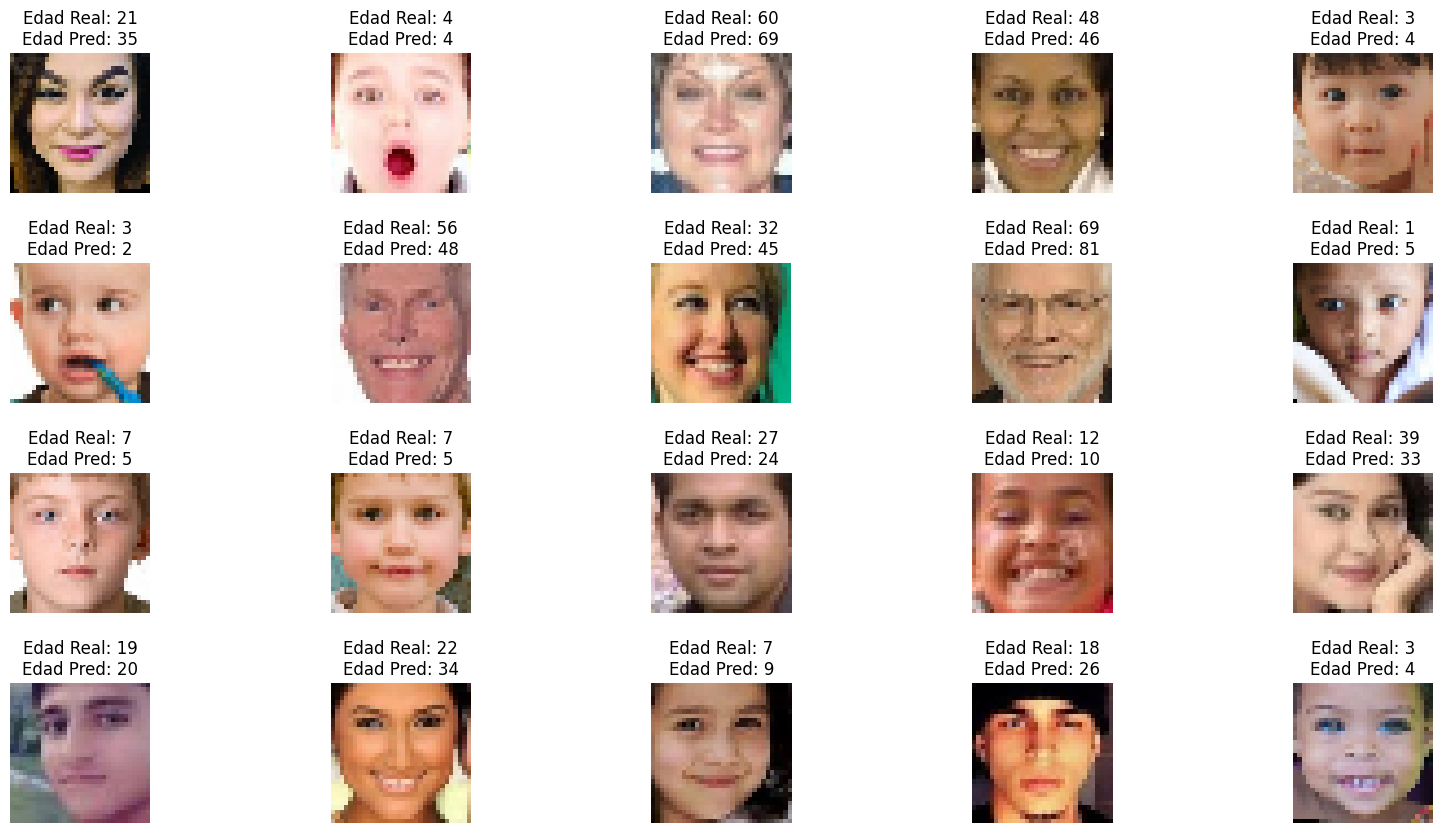

RMSE: 10.458727904590447
R²: 0.81981163631593
(1956, 32, 32, 3)


In [51]:
# Evaluamos el modelo en el conjunto de prueba
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Pérdida en el conjunto de prueba (MSE): {test_loss}")

# Predecimos sobre el conjunto de prueba
predictions = model.predict(X_test)

# Invertimos la normalización para obtener las edades reales y las predichas
y_test_real = scaler.inverse_transform(y_test)
predictions_real = scaler.inverse_transform(predictions)

# Calculamos el RMSE a partir del MSE
mse = mean_squared_error(y_test_real, predictions_real)
rmse = np.sqrt(mse)
print(f"Root Mean Square Error (RMSE) en el conjunto de prueba: {rmse}")

# Desnormalizamos las imágenes para mostrarlas correctamente
X_test_display = (X_test * 255).astype('uint8')  # Convertimos a enteros sin signo después de multiplicar por 255

# Si las imágenes se cargaron en formato BGR, las convertimos a RGB
X_test_display_rgb = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in X_test_display]

# Mostramos 20 ejemplos seleccionados aleatoriamente con la edad real y predicha
indices = np.random.choice(len(X_test_display_rgb), 20, replace=False)
plt.figure(figsize=(20, 10))

# Ajustamos el espaciado entre las subplots
plt.subplots_adjust(hspace=0.5)  # Aumentamos el espacio vertical entre las imágenes

for i, idx in enumerate(indices):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_test_display_rgb[idx])  # Mostramos la imagen desnormalizada y convertida a RGB
    plt.title(f"Edad Real: {int(y_test_real[idx])}\nEdad Pred: {int(predictions_real[idx])}")
    plt.axis('off')

plt.show()

# Calculamos el R² para complementar el RMSE
r2 = r2_score(y_test_real, predictions_real)
print(f"RMSE: {rmse}")
print(f"R²: {r2}")
